# Advertisement Demand Prediction
Special thanks Kaggle. The project utilizes its dataset and it is designed to predict demand for an online advertisement based on an advertisment's different features, such as price, descriptions, its context (geographically where it was posted, similar ads already posted) and historical demand for similar ads in similar contexts.

Thus, for this project, we have many features, denoted as the Xs, including the numerical feature- price, and many categorical/ non- numerical data, such as descriptions. Thus, the first part of this project would include two major parts:
1. Feature Extraction Engineering
2. Text Data NLP Engineering

And, then the model to be used is **LightGBM**, a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel and GPU learning.
- Capable of handling large-scale data.

A quick referece I adviced is from： https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

## Step 1 Import Needed Libraries
The text dataset needs special caution to handle before we can input into the machine leanring model. The text must be parsed to remove words, called $tokenization$. Then the words need to be encoded as integers or floating point values for use as input to a machine learning algorithm, called feature extraction (or vectorization).

The Sklearn library offers the below functions:

1. How to convert text to word count vectors with CountVectorizer.
2. How to convert text to word frequency vectors with TfidfVectorizer.
3. How to convert text to unique integers with HashingVectorizer.

In [1]:
#the numpy array makes an efficient linear algebra calculation, good for high dimensional computation
import numpy as np    
#for an efficient file I/O and data pre- processing
import pandas as pd  
 #to create graphs
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls
#to make graph look beautiful 
import seaborn as sns  
#help us to convert non- numerical data into trainable data
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
import nltk
# nltk.download()
#help us to reduce the dimension of dataset 
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
#this is our main model
import lightgbm as lgb
from io import StringIO
color = sns.color_palette()
sns.set_style("darkgrid")
%matplotlib inline

## Step 2 Data Visualization 
- It is important for us to see which how each features might play an important role for us to make prediction, as too many extra features might become an extraction during our training
- Now let us quickly see how the train/ test *.TXT file look like

In [40]:
train_df = pd.read_csv("train.csv", parse_dates=["activation_date"])
test_df = pd.read_csv("test.csv", parse_dates=["activation_date"])
print("Train file rows and columns are : ", train_df.shape)
print("Test file rows and columns are : ", test_df.shape)


#quickly see visualize it
train_df.head()

Train file rows and columns are :  (1503424, 18)
Test file rows and columns are :  (508438, 17)


,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


From the table shown above, we could see that there are several features (Xs) that would potentially affect the $Deal Probability$ (Y). See the illustration below:

- item_id - Advertisement's posted Id.
- user_id - User id.
- region - The region where the advertisement was posted.
- city - The city where the advertisement was posted.
- parent_category_name - The major advertisement's category, such as, "Personal Belongings"
- category_name - A more detailed category.
- param_1 - Optional parameter.
- param_2 - Optional parameter.
- param_3 - Optional parameter.
- title - The advertisement's title.
- description - The advertisement's description.
- price - The advertisement's price.
- item_seq_number - The advertisement's sequential number.
- activation_date- When the advertisement was posted.
- user_type - User type.
- image_top_1 - Avito's classification code for the image.

From above, we could see that only ***price*** could be directly used as a numerical feature which is trainable.


### Now let us first translate the given dataset into English

- parent_category_name
- region
- category_name

In [41]:
parentCategoryHash = {"Личные вещи" : "Personal belongings",        "Для дома и дачи" : "For the home and garden",
                    "Бытовая электроника" : "Consumer electronics", "Недвижимость" : "Real estate",
                    "Хобби и отдых" : "Hobbies & leisure",          "Транспорт" : "Transport",
                    "Услуги" : "Services",                           "Животные" : "Animals",
                    "Для бизнеса" : "For business"}

regionHash = {"Свердловская область" : "Sverdlovsk oblast",          "Самарская область" : "Samara oblast",
              "Ростовская область" : "Rostov oblast",                 "Татарстан" : "Tatarstan",
            "Волгоградская область" : "Volgograd oblast",            "Нижегородская область" : "Nizhny Novgorod oblast",
            "Пермский край" : "Perm Krai",                           "Оренбургская область" : "Orenburg oblast",
            "Ханты-Мансийский АО" : "Khanty-Mansi Autonomous Okrug", "Тюменская область" : "Tyumen oblast",
            "Башкортостан" : "Bashkortostan",                        "Краснодарский край" : "Krasnodar Krai",
            "Новосибирская область" : "Novosibirsk oblast",          "Омская область" : "Omsk oblast",
            "Белгородская область" : "Belgorod oblast",              "Челябинская область" : "Chelyabinsk oblast",
            "Воронежская область" : "Voronezh oblast",               "Кемеровская область" : "Kemerovo oblast",
            "Саратовская область" : "Saratov oblast",                "Владимирская область" : "Vladimir oblast",
            "Калининградская область" : "Kaliningrad oblast",        "Красноярский край" : "Krasnoyarsk Krai",
            "Ярославская область" : "Yaroslavl oblast",              "Удмуртия" : "Udmurtia",
            "Алтайский край" : "Altai Krai",                         "Иркутская область" : "Irkutsk oblast",
            "Ставропольский край" : "Stavropol Krai",                "Тульская область" : "Tula oblast"}


categoryHash = {"Одежда, обувь, аксессуары":"Clothing, shoes, accessories", 
                "Детская одежда и обувь":"Children's clothing and shoes",
                "Товары для детей и игрушки":"Children's products and toys",
                "Квартиры":"Apartments",
                "Телефоны":"Phones",
                "Мебель и интерьер":"Furniture and interior",
                "Предложение услуг":"Offer services",
                "Автомобили":"Cars",
                "Ремонт и строительство":"Repair and construction",
                "Бытовая техника":"Appliances",
                "Товары для компьютера":"Products for computer",
                "Дома, дачи, коттеджи":"Houses, villas, cottages",
                "Красота и здоровье":"Health and beauty",
                "Аудио и видео":"Audio and video",
                "Спорт и отдых":"Sports and recreation",
                "Коллекционирование":"Collecting",
                "Оборудование для бизнеса":"Equipment for business",
                "Земельные участки":"Land",
                "Часы и украшения":"Watches and jewelry",
                "Книги и журналы":"Books and magazines",
                "Собаки":"Dogs",
                "Игры, приставки и программы":"Games, consoles and software",
                "Другие животные":"Other animals",
                "Велосипеды":"Bikes",
                "Ноутбуки":"Laptops",
                "Кошки":"Cats",
                "Грузовики и спецтехника":"Trucks and buses",
                "Посуда и товары для кухни":"Tableware and goods for kitchen",
                "Растения":"Plants",
                "Планшеты и электронные книги":"Tablets and e-books",
                "Товары для животных":"Pet products",
                "Комнаты":"Room",
                "Фототехника":"Photo",
                "Коммерческая недвижимость":"Commercial property",
                "Гаражи и машиноместа":"Garages and Parking spaces",
                "Музыкальные инструменты":"Musical instruments",
                "Оргтехника и расходники":"Office equipment and consumables",
                "Птицы":"Birds",
                "Продукты питания":"Food",
                "Мотоциклы и мототехника":"Motorcycles and bikes",
                "Настольные компьютеры":"Desktop computers",
                "Аквариум":"Aquarium",
                "Охота и рыбалка":"Hunting and fishing",
                "Билеты и путешествия":"Tickets and travel",
                "Водный транспорт":"Water transport",
                "Готовый бизнес":"Ready business",
                "Недвижимость за рубежом":"Property abroad"}

#now we can create several whole new columns with the translation on
#first let us copy the data from the original and assign them under the translated column
train_df['parent_category_name_en'] = train_df['parent_category_name'].apply(lambda x : parentCategoryHash[x])
train_df['region_en'] = train_df['region'].apply(lambda x : regionHash[x])
train_df['category_name_en'] = train_df['category_name'].apply(lambda x : categoryHash[x])

#now let use arrange them so that each translated is alligned with its original
colnames = train_df.columns.tolist()

#get where these three newly added columns are 
parentCatEnLoc = colnames.index('parent_category_name_en')
parentCatEn = colnames.pop(parentCatEnLoc)

parentCatLoc = colnames.index('parent_category_name')
parentCat = colnames.pop(parentCatLoc)

catEnLoc = colnames.index('category_name_en')
catEn = colnames.pop(catEnLoc)

catLoc = colnames.index('category_name')
cat = colnames.pop(catLoc)

regionEnLoc = colnames.index('region_en')
regionEn = colnames.pop(regionEnLoc)

regionLoc = colnames.index('region')
region = colnames.pop(regionLoc)

#re- create a new column
newCols = [parentCat,parentCatEn, cat, catEn, region, regionEn] + colnames[::]

#re- assign the columns
train_df = train_df[newCols]
train_df.head()

,parent_category_name,parent_category_name_en,category_name,category_name_en,region,region_en,item_id,user_id,city,param_1,...,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,Личные вещи,Personal belongings,Товары для детей и игрушки,Children's products and toys,Свердловская область,Sverdlovsk oblast,b912c3c6a6ad,e00f8ff2eaf9,Екатеринбург,Постельные принадлежности,...,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,Для дома и дачи,For the home and garden,Мебель и интерьер,Furniture and interior,Самарская область,Samara oblast,2dac0150717d,39aeb48f0017,Самара,Другое,...,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,Бытовая электроника,Consumer electronics,Аудио и видео,Audio and video,Ростовская область,Rostov oblast,ba83aefab5dc,91e2f88dd6e3,Ростов-на-Дону,"Видео, DVD и Blu-ray плееры",...,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,Личные вещи,Personal belongings,Товары для детей и игрушки,Children's products and toys,Татарстан,Tatarstan,02996f1dd2ea,bf5cccea572d,Набережные Челны,Автомобильные кресла,...,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,Транспорт,Transport,Автомобили,Cars,Волгоградская область,Volgograd oblast,7c90be56d2ab,ef50846afc0b,Волгоград,С пробегом,...,2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


### Now let us visualize how the target (Deal Probability) distribute and plot its histogram

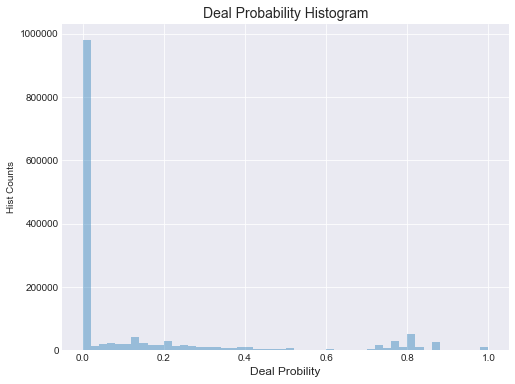

In [4]:
# Visualize the relationship between the deal probability histogram
plt.figure(figsize=(8,6)) 
# This function combines the matplotlib hist function (with automatic calculation of a good default bin size) 
# with the seaborn kdeplot() and rugplot() functions. 
# It can also fit scipy.stats distributions and plot the estimated PDF over the data.
all_probability = train_df['deal_probability'].values 
sns.distplot(all_probability, kde=False) 
plt.xlabel('Deal Probility', fontsize=12)
plt.ylabel("Hist Counts")
plt.title("Deal Probability Histogram", fontsize=14)
plt.show()

From the two graphs above, we could see that most of the items (nearly 71%) remains as unsold, and just few ads helped the item to be sold, and the rest of the deal's probabilities have shown various success rate

### Now let us visualize how the region- wise distribution look like, which might also help

#### A. Directly visualize the region distribution

In [36]:
def create_pie(whichOne, name, dataframe):
    whichOneCounts = dataframe[whichOne].value_counts()
    NameArray = np.array(whichOneCounts.index)

    frequency = np.array((whichOneCounts/ whichOneCounts.sum())*100)

    pieChart = go.Pie(labels= NameArray, values = frequency)
    layout = go.Layout(
        title= name + " Distribution",
        width=700,
        height=700,
    )

    data = [pieChart]
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename=name)

def create_histo(src, whichOne, target, xLabel, yLabel, title):
    plt.figure(figsize=(10,8))
    #use the seaborn for an automatic plotting process
    sns.boxplot(x=whichOne, y=target, data=src)
    plt.xlabel(xLabel, fontsize=12)
    plt.ylabel(yLabel, fontsize=12)
    plt.title(title)
    plt.xticks(rotation= 75)
    plt.show()

In [42]:
create_pie('region_en', 'Region', train_df)

From the Pie Chart, looks like that there are 3 major regions that post most of the ads:
1. Krasnodar region - 9.41%
2. Sverdlovsk region - 6.28%
3. Rostov region - 5.99%

#### B. Let us see the box plot contains the both region information and success probability

In [7]:
porb = train_df['deal_probability']
city = train_df['region_en']
new_box = pd.concat([city,porb], 1)
new_box.head()

,region_en,deal_probability
0,Sverdlovsk oblast,0.12789
1,Samara oblast,0.00000
2,Rostov oblast,0.43177
3,Tatarstan,0.80323
4,Volgograd oblast,0.20797


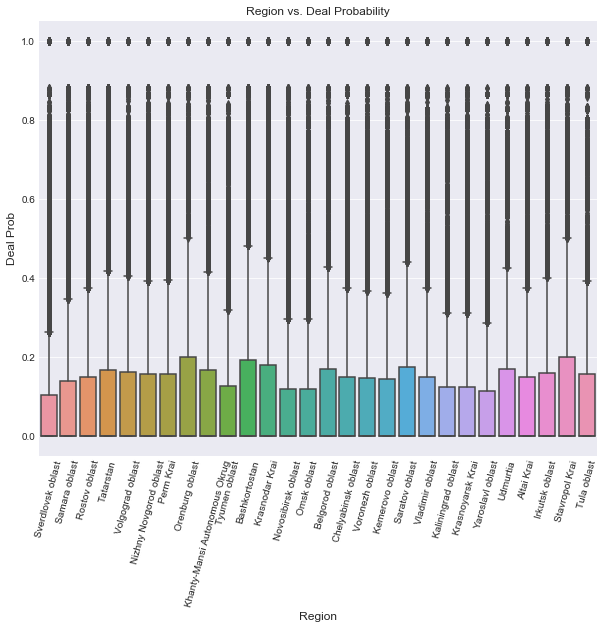

In [8]:
# def create_histo(src, whichOne, target, xLabel, yLabel, title):
create_histo(new_box, 'region_en', 'deal_probability', 'Region', 'Deal Prob', 'Region vs. Deal Probability')

From the box plot above, we can see that the region where the advertisments were posted affect the deal probability with an unknow tendency; that said, the relationship would be non- linear

### Let us see how parent category might affect the deal probability

#### A. Directly visualize how the category distributes

In [43]:
create_pie('parent_category_name_en', 'Parent Category', train_df)

From above, we can see that nearly half of the items being advertised are categorized as **Personal Belongings**; however, does this dominant personal belongings really show any relationship between our target **deal probability**? 

#### B. Now let us see box plot contains the both category information and deal probility

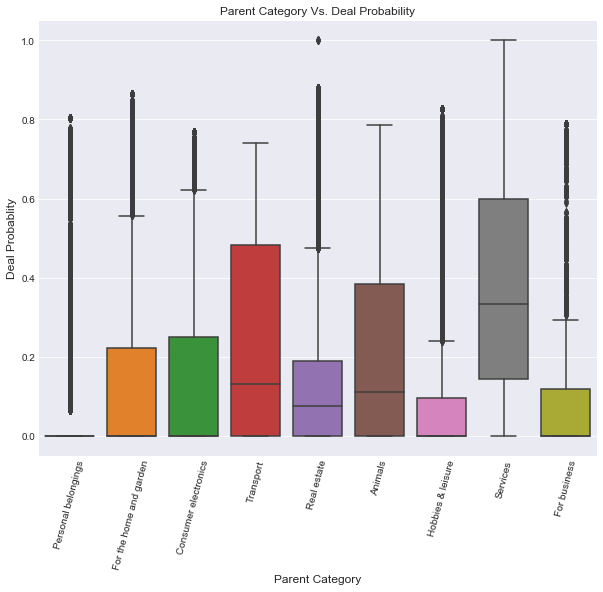

In [10]:
porb = train_df['deal_probability']
city = train_df['parent_category_name_en']
new_box = pd.concat([city,porb], 1)
new_box.head()
create_histo(new_box,"parent_category_name_en", "deal_probability","Parent Category", "Deal Probablity", "Parent Category Vs. Deal Probability")

Definitely, we can see that the category would impact the deal probability where the **Services** shows a significant impact where even its minimal is even greater than most cases' median; whereas, previously we saw **personal belongings** covers the most advertisments, but from our box plot we can see that the coverage does not necessarily bring about a higher deal prob. Then I made an assumption that the feature of **category name** should show the similar tendency.

### Now let us visualize how the user- wise distribution look like

#### A. Directly visualize the user  distribution

In [44]:
create_pie('user_type', 'Parent Type', train_df)

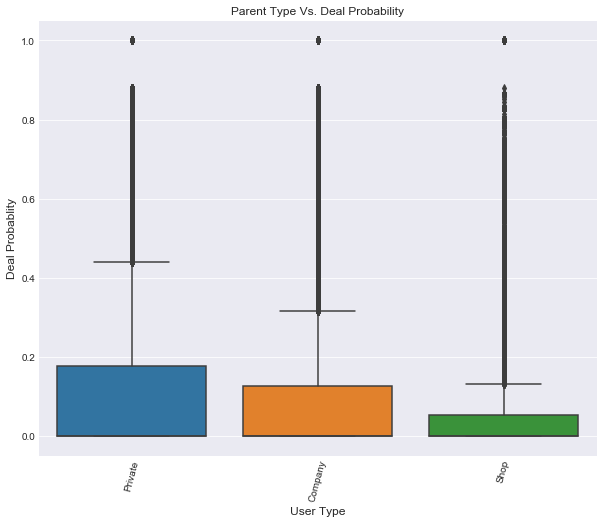

In [12]:
porb = train_df['deal_probability']
city = train_df['user_type']
new_box = pd.concat([city,porb], 1)
new_box.head()
create_histo(new_box,"user_type", "deal_probability","User Type", "Deal Probablity", "Parent Type Vs. Deal Probability")

Similarly, we can see that the **User Type** is also another important feature that would affect our deal probability, and still, the private seller would show a positive impact

## Step 3 Text Data Processing by TFIDF and Sparse Matrix Processing by SVD
As mentioned before, the text data has to be processed into a trainable format, thus, we could apply TFIDF to the **title** and **description**

TFIDF is a measurement for the weights to different words. 
- for a vector of words, we need to give a weight to each word. This is because for a sentence like "This is a Scientific Book"; The words "This" "Is" "a" are the common words which all tend to appear in many different sentences, but the word "Scientific" is a special word which is more meaningful than the other. Thus, when a word has more ability to affect, its weight is more. 
- Thus, the weight is calculated by IDF, which means that if a word only appears few times in some certain sentances, we could utilize this special word to classify the sentence. In turn its weight is higher.
- However, by default, the output from tfidf of Sklearn is a sparse matrix

Thus, we could perform the **SVD** on the top of the output of the TFIDF matrix to extract the top 3 important components from the sparse matrix. By doing this, we could be able to prepare the ONLY useful feature data for training, and meanwhile, we discard extracted/ unuseful data points

In [13]:
def textDataProcesing(whatFor, train_df, test_df, ngram):
    stopWord = 'russian'
    #I decided to use n_gram to be (1,3), meaning that I will generate phrase combinations built by single word, 2 words, and 3 words
    #for example:  if we had the sentence "Python is cool" we'd end up with 6 phrases - 
    #'Python', 'is', 'cool', 'Python is', 'Python is cool' and 'is cool'.
    tv = TfidfVectorizer(max_features=100000, ngram_range=(1,ngram), stop_words=set(stopwords.words(stopWord)))
    trainData = train_df[whatFor].values.tolist()
    testData = test_df[whatFor].values.tolist()
    
    wholeFitting = tv.fit_transform(trainData + testData)
    
    TfidfTrain = tv.transform(trainData)
    TfidfTest = tv.transform(testData)
    
    #as we have a huge dataset, the output from tfidf by fault could be a sparse matrix, 
    #thus, let us just get the top 3 major components
    n_comp = 3
    svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
    
    #fit the data
    svd_obj.fit(wholeFitting)  #first we must fit the dataset
    trainSVD = pd.DataFrame(svd_obj.transform(TfidfTrain)) #then transform
    testSVD = pd.DataFrame(svd_obj.transform(TfidfTest))
    
    #rename the generated svd components so that we can concat them into our original dataset
    trainSVD.columns = [whatFor + '_svd_' + str(i+1) for i in range(n_comp)]
    testSVD.columns = [whatFor + '_svd_' + str(i+1) for i in range(n_comp)]
    
    #insert the 3 svd components into our dataframe
    train_df = pd.concat([train_df, trainSVD], axis=1)
    test_df = pd.concat([test_df, testSVD], axis=1)
    
    return train_df, test_df

In [14]:
train_df, test_df = textDataProcesing("title", train_df, test_df, 3)

In [15]:
train_df["description"].fillna("NA", inplace=True)
test_df["description"].fillna("NA", inplace=True)
train_df, test_df = textDataProcesing("description", train_df, test_df, 3)

In [16]:
train_df.head()

,parent_category_name,parent_category_name_en,category_name,category_name_en,region,region_en,item_id,user_id,city,param_1,...,user_type,image,image_top_1,deal_probability,title_svd_1,title_svd_2,title_svd_3,description_svd_1,description_svd_2,description_svd_3
0,Личные вещи,Personal belongings,Товары для детей и игрушки,Children's products and toys,Свердловская область,Sverdlovsk oblast,b912c3c6a6ad,e00f8ff2eaf9,Екатеринбург,Постельные принадлежности,...,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789,2.989713e-06,9.159485e-07,1.001478e-05,1.086849e-08,0.008738,0.003883
1,Для дома и дачи,For the home and garden,Мебель и интерьер,Furniture and interior,Самарская область,Samara oblast,2dac0150717d,39aeb48f0017,Самара,Другое,...,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000,1.770524e-05,1.519780e-05,6.847569e-05,4.088450e-10,0.001334,0.000459
2,Бытовая электроника,Consumer electronics,Аудио и видео,Audio and video,Ростовская область,Rostov oblast,ba83aefab5dc,91e2f88dd6e3,Ростов-на-Дону,"Видео, DVD и Blu-ray плееры",...,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177,9.399167e-06,9.815578e-05,1.600757e-05,2.686430e-08,0.164307,-0.101157
3,Личные вещи,Personal belongings,Товары для детей и игрушки,Children's products and toys,Татарстан,Tatarstan,02996f1dd2ea,bf5cccea572d,Набережные Челны,Автомобильные кресла,...,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323,5.364694e-05,5.530519e-05,1.820150e-05,3.244059e-08,0.026159,0.005975
4,Транспорт,Transport,Автомобили,Cars,Волгоградская область,Volgograd oblast,7c90be56d2ab,ef50846afc0b,Волгоград,С пробегом,...,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797,4.457257e-07,3.199200e-06,6.300643e-07,3.380988e-09,0.026297,0.002042


### Step 4, converting the categorical data into trainable fashion
- we will perform **Label Encoding** for other categorical data, such as we would convert different category into 0 indexed representation {0, 1, 2, 3 ....}

- discard unuseful features

- make use of the feature of "activation date" - > convert it into days' counts 

In [17]:
def labelEncoding(whichCols, train_df, test_df):
    for col in whichCols:
        labelEncoder = preprocessing.LabelEncoder()
        #need to make sure that our labeling covers all the dataset
        data = list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str'))
        #fit the data
        labelEncoder.fit(data)
        #transform the corresponding data
        train_df[col] = labelEncoder.transform(list(train_df[col].values.astype('str')))
        test_df[col] = labelEncoder.transform(list(test_df[col].values.astype('str')))
    return train_df, test_df

In [18]:
# New variable on weekday #
train_df["activation_weekday"] = train_df["activation_date"].dt.weekday
test_df["activation_weekday"] = test_df["activation_date"].dt.weekday

#define all the columns needed to be converted
categoricalColumns = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3"]
train_df, test_df = labelEncoding(categoricalColumns, train_df, test_df)

#get the test dataset's info out
testId = test_df["item_id"].values

#labels
labels = train_df['deal_probability'].values

In [19]:
#discard unuseful features
trainDisColumns = ["item_id", "user_id", "title", "description", "activation_date", "image",
                   "region_en", "parent_category_name_en", "category_name_en", 'deal_probability'] 
testDisColumns=  ["item_id", "user_id", "title", "description", "activation_date", "image"]
trainData = train_df.drop(trainDisColumns, axis=1)
testData = test_df.drop(testDisColumns, axis=1)
trainData.head()

,parent_category_name,category_name,region,city,param_1,param_2,param_3,price,item_seq_number,user_type,image_top_1,title_svd_1,title_svd_2,title_svd_3,description_svd_1,description_svd_2,description_svd_3,activation_weekday
0,4,42,19,462,249,112,1217,400.0,2,1,1008.0,2.989713e-06,9.159485e-07,1.001478e-05,1.086849e-08,0.008738,0.003883,1
1,2,22,17,1314,122,112,1217,3000.0,19,1,692.0,1.770524e-05,1.519780e-05,6.847569e-05,4.088450e-10,0.001334,0.000459,6
2,0,2,16,1290,84,112,1217,4000.0,9,1,3032.0,9.399167e-06,9.815578e-05,1.600757e-05,2.686430e-08,0.164307,-0.101157,0
3,4,42,21,950,38,112,1217,2200.0,286,0,796.0,5.364694e-05,5.530519e-05,1.820150e-05,3.244059e-08,0.026159,0.005975,5
4,6,0,4,318,278,124,46,40000.0,3,1,2264.0,4.457257e-07,3.199200e-06,6.300643e-07,3.380988e-09,0.026297,0.002042,3


In [21]:
testDataCopy = testData[::][::]
testDataCopy.head()

,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,item_seq_number,user_type,image_top_1,title_svd_1,title_svd_2,title_svd_3,description_svd_1,description_svd_2,description_svd_3,activation_weekday
0,4,318,4,10,110,198,74,NaN,66,1,2020.0,0.000091,0.000026,0.000094,0.000000e+00,0.000000,0.000000,1
1,19,993,8,5,119,112,1217,3000.0,4,1,NaN,0.009328,0.000491,0.001885,3.102530e-08,0.112152,0.011004,6
2,12,151,0,2,318,112,1217,15000.0,15,1,2960.0,0.000002,0.000005,0.000001,3.635717e-08,0.023009,0.007397,0
3,18,1319,2,4,108,131,1217,4500.0,70,1,NaN,0.000089,0.018787,0.000114,8.615036e-08,0.020858,0.006202,0
4,14,243,4,42,102,112,1217,4900.0,15,1,1002.0,0.000269,0.000038,0.002318,7.559171e-08,0.033642,0.006118,5


### Step 5 Modeling with LightGBM

In [25]:
def runModel(trainData, labels, testData, maxIter):
    params = {"objective" : "regression", "metric" : "rmse", "num_leaves" : 35, "learning_rate" : 0.01,
    "bagging_fraction" : 0.7, "feature_fraction" : 0.7, "bagging_frequency" : 5, "bagging_seed" : 2018,
    "verbosity" : -1}
    
    from sklearn.model_selection import train_test_split
    trainX, valX, trainy, valy = train_test_split(trainData, labels, test_size=0.3, random_state= 1)
    
    trainDataSet = lgb.Dataset(trainX, label=trainy)
    valDataSet = lgb.Dataset(valX, label=valy)
    evaluation = {}
    model = lgb.train(params, trainDataSet, maxIter, valid_sets=[valDataSet], 
                      early_stopping_rounds=100, verbose_eval=20, evals_result=evaluation)
    
    predY = model.predict(testData, num_iteration=model.best_iteration)
    return predY, model, evaluation

In [26]:
# Training the model #
prediction, model, evaluation = runModel(trainData, labels, testData,2500)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's rmse: 0.253413
[40]	valid_0's rmse: 0.248638
[60]	valid_0's rmse: 0.245142
[80]	valid_0's rmse: 0.24251
[100]	valid_0's rmse: 0.240499
[120]	valid_0's rmse: 0.239007
[140]	valid_0's rmse: 0.237842
[160]	valid_0's rmse: 0.236891
[180]	valid_0's rmse: 0.236175
[200]	valid_0's rmse: 0.235574
[220]	valid_0's rmse: 0.2351
[240]	valid_0's rmse: 0.234654
[260]	valid_0's rmse: 0.234282
[280]	valid_0's rmse: 0.233951
[300]	valid_0's rmse: 0.233651
[320]	valid_0's rmse: 0.23336
[340]	valid_0's rmse: 0.23311
[360]	valid_0's rmse: 0.23287
[380]	valid_0's rmse: 0.232666
[400]	valid_0's rmse: 0.232471
[420]	valid_0's rmse: 0.232294
[440]	valid_0's rmse: 0.232156
[460]	valid_0's rmse: 0.232015
[480]	valid_0's rmse: 0.23189
[500]	valid_0's rmse: 0.231777
[520]	valid_0's rmse: 0.231661
[540]	valid_0's rmse: 0.231549
[560]	valid_0's rmse: 0.231451
[580]	valid_0's rmse: 0.231357
[600]	valid_0's rmse: 0.23127
[620]	valid_0's rms

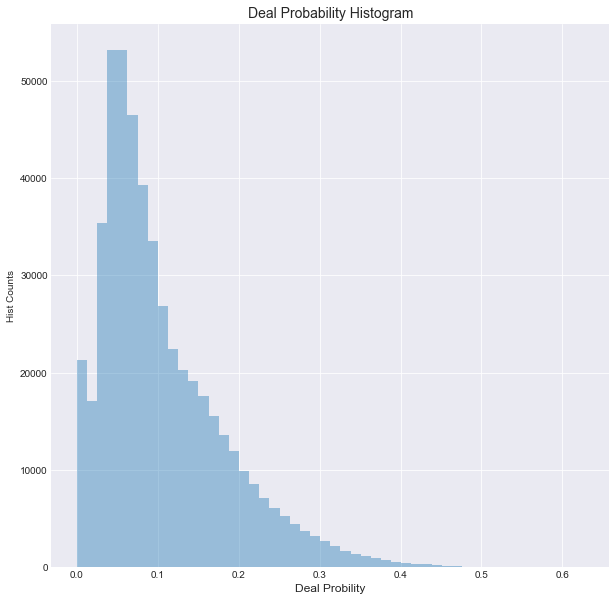

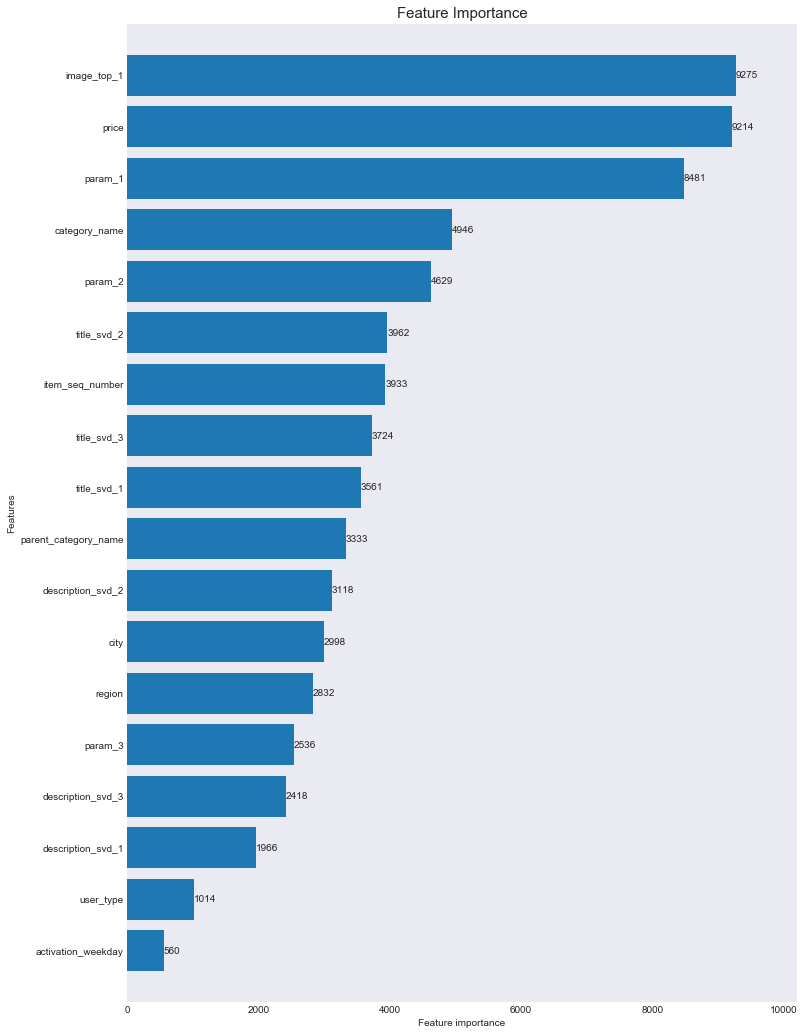

In [50]:
predictionCopy = prediction[::]

#just in case our prediction have values larger than 1, which is not possible
predictionCopy[predictionCopy>1] = 1
#just in case our prediction have values less than 0, which is not possible
predictionCopy[predictionCopy<0] = 0

#prediction DataFrame
pred_df = pd.DataFrame({"item_id":testId})
pred_df["deal_probability"] = predictionCopy

#save our prediction results
pred_df.to_csv("prediction.csv", index=False)

#let us see how is our probability distributed
plt.figure(figsize= (10,10))
pred_probability = pred_df['deal_probability'].values 
sns.distplot(all_probability, kde=False) 
plt.xlabel('Deal Probility', fontsize=12)
plt.ylabel("Hist Counts")
plt.title("Deal Probability Histogram", fontsize=14)
plt.show()

#let us see which feature plays an important role
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("Feature Importance", fontsize=15)
plt.show()

From the above, we can see that the predicted deal probability shows a similar disbution, which is also right skewed. Still, we can see that it is hard to make a good advertisement to achieve a good deal probability. Meanwhile, with the analysis, we can see that in order to make a higher successful rate, a seller should focus more on the top features :
- "image_top_1" which is the image category code. Thus this means that we should pay attention to what image we post with advertisement
- "Price". Definitely, the price should be reasonable
- "param_1": optional parameter. This means that when one post his/ her advertisement, he/ she should label the advertisement with more detailedly